In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import time
import glob
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
import time
import pandas as pd
from tensorflow.keras.optimizers import Adam


NAME = "Tcc_cnn_64_{}".format(int(time.time()))

In [2]:

print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    

print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Default GPU Device: /device:GPU:0
True


### Carregando arquivos

In [2]:
all_traning_paths = glob.glob('DATASETS/TRAINING/*/*.jpg')
all_val_paths = glob.glob('DATASETS/VALIDATION/*/*.jpg')

DATASETS/TRAINING\WITHOUT-CANCER\1-017 (1).jpg


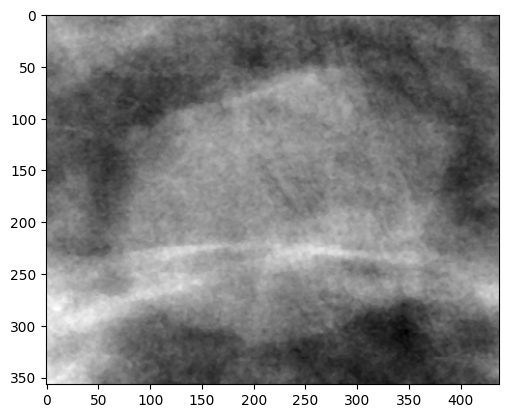

In [20]:
img_path=random.choice(all_traning_paths)
cropped_img = Image.open(img_path)

gray = cropped_img.convert('L')
#median =cv2.blur(np.array(gray), (3, 3))
#aplicando filtro para reduzir ruido
median = cv2.medianBlur(np.array(gray), 3)
print(img_path)
plt.imshow(median, cmap='gray')

# Criando datagens

In [5]:
datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen_resnet.flow_from_directory('DATASETS/Training-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=16 
                            )


validation_gen = datagen_resnet.flow_from_directory('DATASETS/Validation-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=16
                            )

test_gen = datagen_resnet.flow_from_directory('DATASETS/Testing-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=16,
                            
                            )

Found 945 images belonging to 2 classes.
Found 146 images belonging to 2 classes.
Found 464 images belonging to 2 classes.


In [6]:
base_model=ResNet50(include_top=False,
                    input_shape=(224,224,3)
)

for layer in base_model.layers:  # ´Passo para eu não retreinar as camadas do RESNET
    layer.trainable=False
    
    tensorBoard = TensorBoard(log_dir='logs/{}'.format(NAME))

# Modelo inicial


In [7]:
modelo = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo.summary() ## me 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
______________________________________

In [8]:
modelo.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history = modelo.fit(train_gen, 
           validation_data=validation_gen,
           epochs=10,
           batch_size=16,
           callbacks=[tensorBoard]
        )

Epoch 1/10
60/60 [==============================] - 13s 57ms/step - loss: 0.7535 - accuracy: 0.5566 - val_loss: 0.6851 - val_accuracy: 0.5890
Epoch 2/10
60/60 [==============================] - 3s 43ms/step - loss: 0.6440 - accuracy: 0.6392 - val_loss: 0.6757 - val_accuracy: 0.6233
Epoch 3/10
60/60 [==============================] - 3s 42ms/step - loss: 0.6044 - accuracy: 0.6677 - val_loss: 0.6401 - val_accuracy: 0.6575
Epoch 4/10
60/60 [==============================] - 3s 42ms/step - loss: 0.5624 - accuracy: 0.7005 - val_loss: 0.6404 - val_accuracy: 0.6438
Epoch 5/10
60/60 [==============================] - 3s 44ms/step - loss: 0.5589 - accuracy: 0.7005 - val_loss: 0.6151 - val_accuracy: 0.6712
Epoch 6/10
60/60 [==============================] - 3s 43ms/step - loss: 0.5149 - accuracy: 0.7598 - val_loss: 0.6115 - val_accuracy: 0.6781
Epoch 7/10
60/60 [==============================] - 3s 44ms/step - loss: 0.5056 - accuracy: 0.7693 - val_loss: 0.6108 - val_accuracy: 0.6781
Epoch 8/10
6

In [9]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.753492,0.556614,0.685075,0.589041
1,0.644023,0.639153,0.675698,0.623288
2,0.604379,0.667725,0.640057,0.657534
3,0.562373,0.700529,0.640370,0.643836
4,0.558892,0.700529,0.615067,0.671233
5,0.514859,0.759788,0.611495,0.678082
6,0.505593,0.769312,0.610784,0.678082
7,0.490554,0.761905,0.591738,0.678082
8,0.468376,0.772487,0.593174,0.691781
9,0.470836,0.765079,0.591003,0.671233


<Axes: >

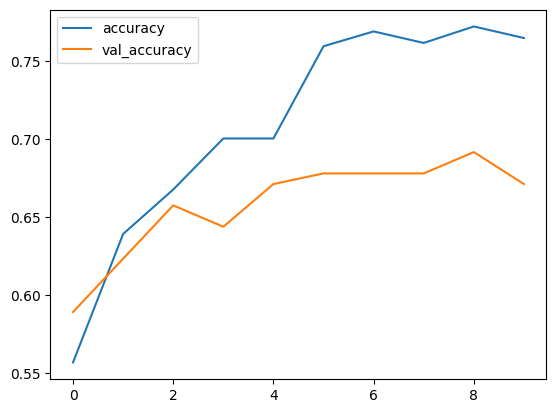

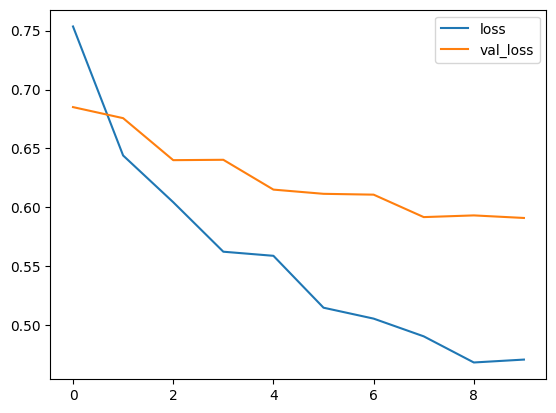

In [10]:

df = pd.DataFrame(history.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

# Modelo 2 Aumentando as camadas

In [11]:
modelo2 = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
____________________________________

In [12]:
modelo2.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )
history = modelo2.fit(train_gen, 
           validation_data=validation_gen,
           epochs=15,
           batch_size=16,
           callbacks=[tensorBoard]
        )

Epoch 1/15
60/60 [==============================] - 5s 56ms/step - loss: 0.7599 - accuracy: 0.5683 - val_loss: 0.7099 - val_accuracy: 0.6233
Epoch 2/15
60/60 [==============================] - 3s 44ms/step - loss: 0.6677 - accuracy: 0.6317 - val_loss: 0.6942 - val_accuracy: 0.5959
Epoch 3/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6014 - accuracy: 0.6836 - val_loss: 0.6616 - val_accuracy: 0.5890
Epoch 4/15
60/60 [==============================] - 3s 42ms/step - loss: 0.5691 - accuracy: 0.6952 - val_loss: 0.6365 - val_accuracy: 0.5959
Epoch 5/15
60/60 [==============================] - 3s 43ms/step - loss: 0.5244 - accuracy: 0.7418 - val_loss: 0.6501 - val_accuracy: 0.5890
Epoch 6/15
60/60 [==============================] - 3s 43ms/step - loss: 0.5228 - accuracy: 0.7280 - val_loss: 0.6416 - val_accuracy: 0.6507
Epoch 7/15
60/60 [==============================] - 3s 44ms/step - loss: 0.5159 - accuracy: 0.7302 - val_loss: 0.6465 - val_accuracy: 0.6096
Epoch 8/15
60

In [13]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.759903,0.568254,0.709909,0.623288
1,0.667656,0.631746,0.694188,0.595890
2,0.601387,0.683598,0.661586,0.589041
3,0.569085,0.695238,0.636529,0.595890
4,0.524445,0.741799,0.650144,0.589041
5,0.522804,0.728042,0.641632,0.650685
6,0.515900,0.730159,0.646549,0.609589
7,0.485738,0.748148,0.632361,0.609589
8,0.455683,0.794709,0.634818,0.616438
9,0.449658,0.785185,0.635210,0.636986


<Axes: >

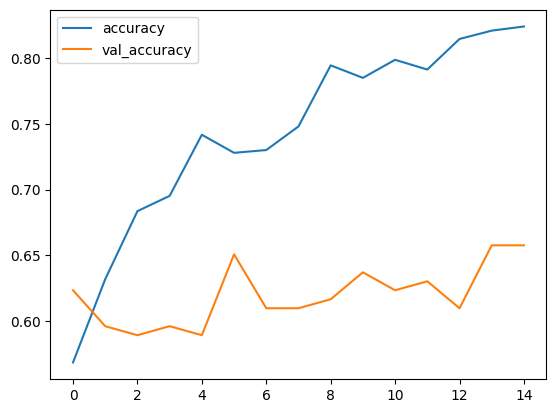

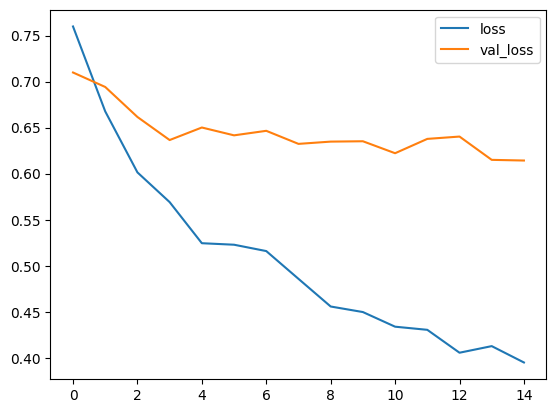

In [15]:
df = pd.DataFrame(history.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

## Modelo 3 ADICIONANDO MAIS UMA CADMADA DENSE E UMA DE DROPOUT


In [16]:
modelo3 = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

In [17]:
modelo3.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history3 = modelo3.fit(train_gen, 
           validation_data=validation_gen,
           epochs=15,
           batch_size=16,
           callbacks=[tensorBoard]
        )

Epoch 1/15
60/60 [==============================] - 5s 54ms/step - loss: 0.7300 - accuracy: 0.5608 - val_loss: 0.6764 - val_accuracy: 0.5685
Epoch 2/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6484 - accuracy: 0.6254 - val_loss: 0.6762 - val_accuracy: 0.5890
Epoch 3/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6380 - accuracy: 0.6508 - val_loss: 0.6578 - val_accuracy: 0.6233
Epoch 4/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6046 - accuracy: 0.6783 - val_loss: 0.6514 - val_accuracy: 0.6575
Epoch 5/15
60/60 [==============================] - 3s 43ms/step - loss: 0.5811 - accuracy: 0.6804 - val_loss: 0.6437 - val_accuracy: 0.6644
Epoch 6/15
60/60 [==============================] - 3s 43ms/step - loss: 0.5639 - accuracy: 0.7090 - val_loss: 0.6384 - val_accuracy: 0.6233
Epoch 7/15
60/60 [==============================] - 3s 44ms/step - loss: 0.5478 - accuracy: 0.7344 - val_loss: 0.6268 - val_accuracy: 0.6712
Epoch 8/15
60

In [18]:
pd.DataFrame(history3.history)

,loss,accuracy,val_loss,val_accuracy
0,0.730000,0.560847,0.676440,0.568493
1,0.648435,0.625397,0.676223,0.589041
2,0.638014,0.650794,0.657828,0.623288
3,0.604642,0.678307,0.651429,0.657534
4,0.581074,0.680423,0.643710,0.664384
5,0.563901,0.708995,0.638448,0.623288
6,0.547844,0.734392,0.626763,0.671233
7,0.515010,0.743915,0.617181,0.684932
8,0.511602,0.728042,0.620384,0.671233
9,0.514208,0.739683,0.631126,0.650685


<Axes: >

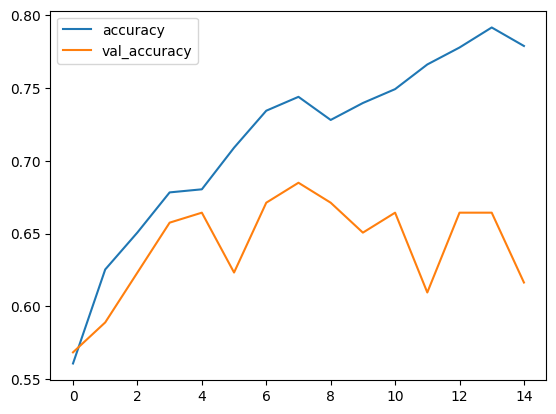

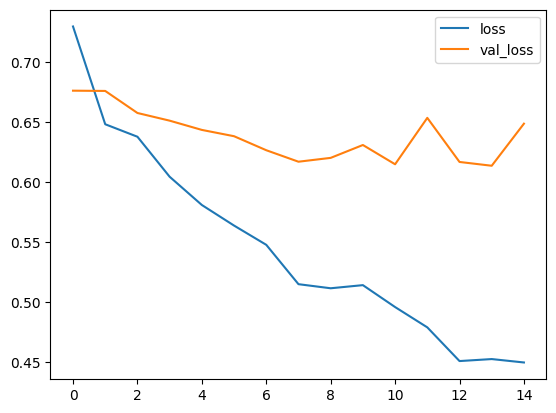

In [19]:
df = pd.DataFrame(history3.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

# Adicionando ao modelo 3 mais uma dense e de dropout 

In [20]:
modelo4 = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.4),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(32, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 128)               262272    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [21]:
modelo4.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history3 = modelo4.fit(train_gen, 
           validation_data=validation_gen,
           epochs=15,
           batch_size=16,
           callbacks=[tensorBoard]
        )

Epoch 1/15
60/60 [==============================] - 6s 54ms/step - loss: 0.8431 - accuracy: 0.4815 - val_loss: 0.6737 - val_accuracy: 0.5685
Epoch 2/15
60/60 [==============================] - 3s 43ms/step - loss: 0.7237 - accuracy: 0.5545 - val_loss: 0.6704 - val_accuracy: 0.5890
Epoch 3/15
60/60 [==============================] - 3s 44ms/step - loss: 0.6861 - accuracy: 0.5947 - val_loss: 0.6666 - val_accuracy: 0.6164
Epoch 4/15
60/60 [==============================] - 3s 44ms/step - loss: 0.6935 - accuracy: 0.5810 - val_loss: 0.6657 - val_accuracy: 0.5959
Epoch 5/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6719 - accuracy: 0.6000 - val_loss: 0.6692 - val_accuracy: 0.5548
Epoch 6/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6740 - accuracy: 0.6074 - val_loss: 0.6648 - val_accuracy: 0.6096
Epoch 7/15
60/60 [==============================] - 3s 44ms/step - loss: 0.6414 - accuracy: 0.6296 - val_loss: 0.6570 - val_accuracy: 0.5959
Epoch 8/15
60

In [22]:
pd.DataFrame(history3.history)

,loss,accuracy,val_loss,val_accuracy
0,0.843121,0.481481,0.673684,0.568493
1,0.723682,0.554497,0.670413,0.589041
2,0.686067,0.594709,0.666642,0.616438
3,0.693518,0.580952,0.665650,0.595890
4,0.671918,0.600000,0.669199,0.554795
5,0.673999,0.607407,0.664767,0.609589
6,0.641436,0.629630,0.657030,0.595890
7,0.648265,0.626455,0.645025,0.623288
8,0.636314,0.635979,0.650180,0.630137
9,0.631558,0.647619,0.641797,0.623288


<Axes: >

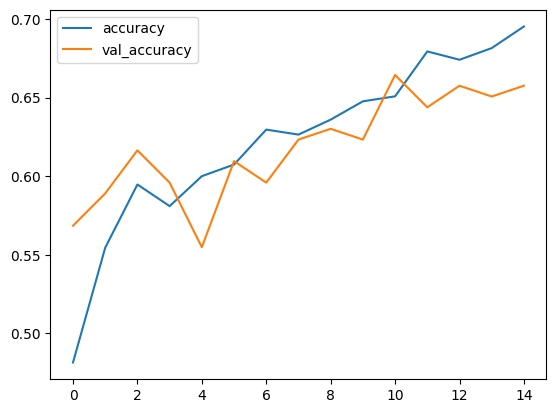

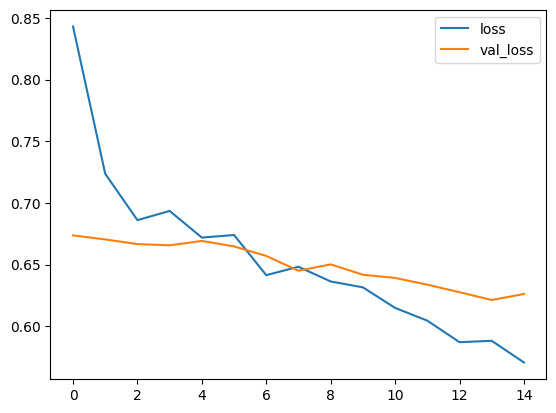

In [23]:
df = pd.DataFrame(history3.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

# Aumentando o bach size com base no modelo 3 ------------MODELO UTILIZADO


In [7]:
datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_32 = datagen_resnet.flow_from_directory('DATASETS/Training-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32 
                            )


validation_gen_32 = datagen_resnet.flow_from_directory('DATASETS/Validation-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32
                            )

Found 945 images belonging to 2 classes.
Found 146 images belonging to 2 classes.


In [8]:
modelo_op = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo_op.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [9]:
modelo_op.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history_op = modelo_op.fit(train_gen_32, 
           validation_data=validation_gen_32,
           epochs=15,
           batch_size=32,
           callbacks=[tensorBoard]
        )

Epoch 1/15
30/30 [==============================] - 11s 107ms/step - loss: 0.7826 - accuracy: 0.5513 - val_loss: 0.7033 - val_accuracy: 0.5342
Epoch 2/15
30/30 [==============================] - 2s 75ms/step - loss: 0.7023 - accuracy: 0.5841 - val_loss: 0.6717 - val_accuracy: 0.5685
Epoch 3/15
30/30 [==============================] - 2s 78ms/step - loss: 0.6649 - accuracy: 0.6180 - val_loss: 0.6552 - val_accuracy: 0.5548
Epoch 4/15
30/30 [==============================] - 2s 76ms/step - loss: 0.6449 - accuracy: 0.6392 - val_loss: 0.6446 - val_accuracy: 0.5822
Epoch 5/15
30/30 [==============================] - 2s 78ms/step - loss: 0.6189 - accuracy: 0.6455 - val_loss: 0.6437 - val_accuracy: 0.6096
Epoch 6/15
30/30 [==============================] - 2s 76ms/step - loss: 0.5989 - accuracy: 0.6868 - val_loss: 0.6443 - val_accuracy: 0.6301
Epoch 7/15
30/30 [==============================] - 2s 79ms/step - loss: 0.5678 - accuracy: 0.7016 - val_loss: 0.6551 - val_accuracy: 0.5822
Epoch 8/15


<Axes: >

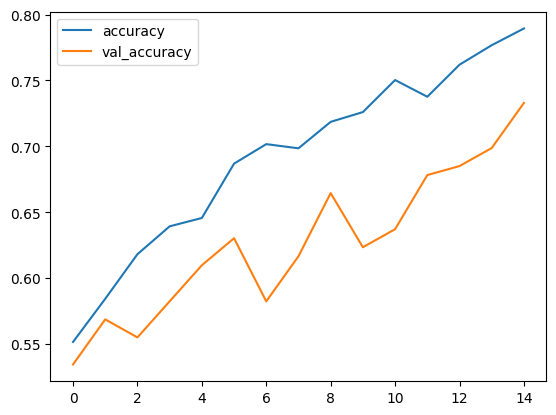

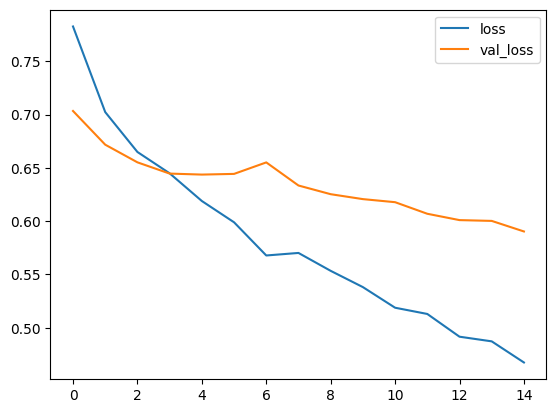

In [10]:
df = pd.DataFrame(history_op.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

# reduzindo epocas do modelo op de 15 para 9

In [28]:
modelo_nove = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo_nove.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 128)               262272    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                      

In [29]:
modelo_nove.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history_nove = modelo_nove.fit(train_gen_32, 
           validation_data=validation_gen_32,
           epochs=9,
           batch_size=32,
           callbacks=[tensorBoard]
        )

Epoch 1/9
30/30 [==============================] - 5s 94ms/step - loss: 0.7292 - accuracy: 0.5757 - val_loss: 0.6842 - val_accuracy: 0.5753
Epoch 2/9
30/30 [==============================] - 2s 70ms/step - loss: 0.6561 - accuracy: 0.6180 - val_loss: 0.6731 - val_accuracy: 0.5548
Epoch 3/9
30/30 [==============================] - 2s 72ms/step - loss: 0.6408 - accuracy: 0.6275 - val_loss: 0.6877 - val_accuracy: 0.5685
Epoch 4/9
30/30 [==============================] - 2s 70ms/step - loss: 0.6053 - accuracy: 0.6476 - val_loss: 0.6593 - val_accuracy: 0.6507
Epoch 5/9
30/30 [==============================] - 2s 71ms/step - loss: 0.5867 - accuracy: 0.6741 - val_loss: 0.6521 - val_accuracy: 0.6233
Epoch 6/9
30/30 [==============================] - 2s 70ms/step - loss: 0.5775 - accuracy: 0.6974 - val_loss: 0.6484 - val_accuracy: 0.6438
Epoch 7/9
30/30 [==============================] - 2s 70ms/step - loss: 0.5568 - accuracy: 0.6974 - val_loss: 0.6404 - val_accuracy: 0.6438
Epoch 8/9
30/30 [===

<Axes: >

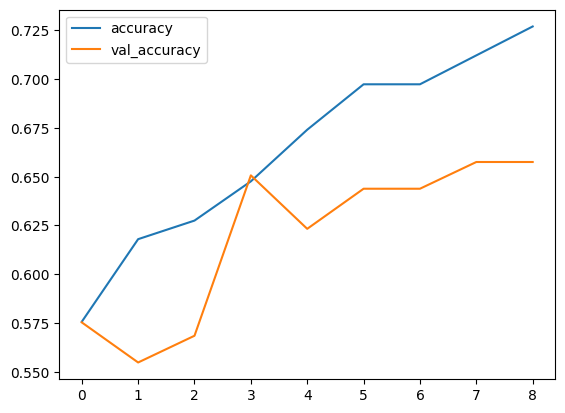

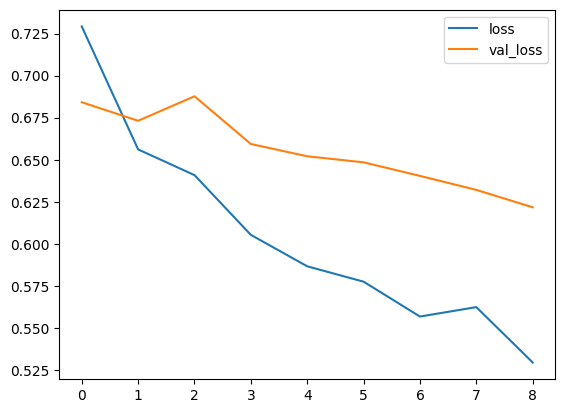

In [30]:
pd2 = pd.DataFrame(history_nove.history)

pd2[['accuracy', 'val_accuracy']].plot()
pd2[['loss', 'val_loss']].plot()


# predições

In [18]:
predictions = modelo_op.predict(test_gen, verbose=1)


29/29 [==============================] - 1s 41ms/step


import numpy as np

labels = (test_gen.class_indices)
res = tf.math.confusion_matrix(labels=test_gen.classes.astype(int), predictions=np.argmax(np.array(predictions).reshape(-1, 2), axis=1))

In [19]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
classes_name = ('cancer', 'sem cancer')
height, width = (224, 224)


test_set = test_gen
test_set.reset()
y_pred = np.argmax(predictions, axis=-1)

y_test = test_gen.labels
cm = confusion_matrix(y_test,y_pred)

print(cm)

cm2 = classification_report(test_gen.classes, y_pred)

print(classification_report(test_gen.classes, y_pred))


file = open('time_bin_metrics.txt', 'w')
file.write('tempo %s' % cm2)
file.close()


[[131 103]
 [109 121]]
              precision    recall  f1-score   support

           0       0.55      0.56      0.55       234
           1       0.54      0.53      0.53       230

    accuracy                           0.54       464
   macro avg       0.54      0.54      0.54       464
weighted avg       0.54      0.54      0.54       464



[[131 103]
 [109 121]]


<Axes: >

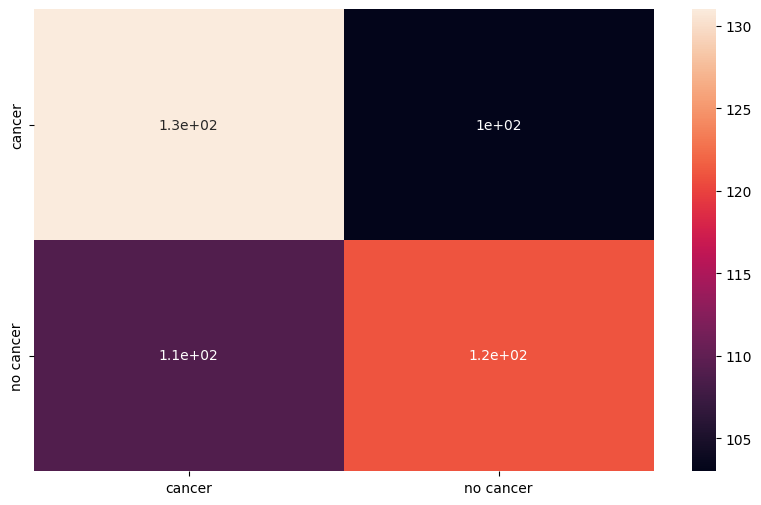

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(cm)
index = ['cancer','no cancer']  
columns = ['cancer','no cancer']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [18]:
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [21]:
epochs = 10

In [24]:
all_traning_paths_cross_val = glob.glob('DATASETS/treino/*/*.jpg')

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

# Armazena os resultados do treinamento em cada fold
all_histories_res = []

In [37]:
# Se você já possui a lista de caminhos, pode criar um ImageDataGenerator separado para os dados de validação
datagen_resnet_train = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.25)
datagen_resnet_val = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.25)



# Crie geradores de dados separados para treinamento e validação
train_gen = datagen_resnet_train.flow_from_directory('DATASETS/treino/',
                            target_size=(224, 224),
                            class_mode="categorical",
                            batch_size=16,
                            subset="training"
                            )

val_gen = datagen_resnet_val.flow_from_directory('DATASETS/treino/',
                            target_size=(224, 224),
                            class_mode="categorical",
                            batch_size=16,
                            subset="validation"
                            )


test_gen = datagen_resnet.flow_from_directory('DATASETS/TESTING/',
                            target_size=(224, 224),
                            class_mode="categorical",
                            batch_size=16
                            )

Found 819 images belonging to 2 classes.
Found 272 images belonging to 2 classes.
Found 464 images belonging to 2 classes.


In [38]:
# Para os dados de treinamento
train_gen = datagen_resnet_train.flow_from_directory('DATASETS/treino/',
                            target_size=(224, 224),
                            class_mode="categorical",
                            batch_size=16,
                            subset="training"
                            )

# Para os dados de validação
val_gen = datagen_resnet_val.flow_from_directory('DATASETS/treino/',
                            target_size=(224, 224),
                            class_mode="categorical",
                            batch_size=16,
                            subset="validation"
                            )

# Substitua X_train e y_train pelos caminhos dos arquivos e rótulos correspondentes dos dados de treinamento
X_train, y_train = train_gen.filepaths, train_gen.classes

# Substitua X_val e y_val pelos caminhos dos arquivos e rótulos correspondentes dos dados de validação
X_val, y_val = val_gen.filepaths, val_gen.classes


Found 819 images belonging to 2 classes.
Found 272 images belonging to 2 classes.


Fold 1/5
Epoch 1/10
55/55 [==============================] - 15s 151ms/step - loss: 0.0435 - accuracy: 0.9908 - val_loss: 5.5336e-04 - val_accuracy: 1.0000
Epoch 2/10
55/55 [==============================] - 6s 116ms/step - loss: 1.0093e-04 - accuracy: 1.0000 - val_loss: 5.5558e-04 - val_accuracy: 1.0000
Epoch 3/10
55/55 [==============================] - 7s 128ms/step - loss: 7.1836e-05 - accuracy: 1.0000 - val_loss: 4.0331e-04 - val_accuracy: 1.0000
Epoch 4/10
55/55 [==============================] - 7s 128ms/step - loss: 5.6461e-05 - accuracy: 1.0000 - val_loss: 2.8851e-04 - val_accuracy: 1.0000
Epoch 5/10
55/55 [==============================] - 8s 138ms/step - loss: 4.4197e-05 - accuracy: 1.0000 - val_loss: 1.8584e-04 - val_accuracy: 1.0000
Epoch 6/10
55/55 [==============================] - 7s 132ms/step - loss: 3.4774e-05 - accuracy: 1.0000 - val_loss: 1.2329e-04 - val_accuracy: 1.0000
Epoch 7/10
55/55 [==============================] - 7s 131ms/step - loss: 2.4135e-05 - accurac

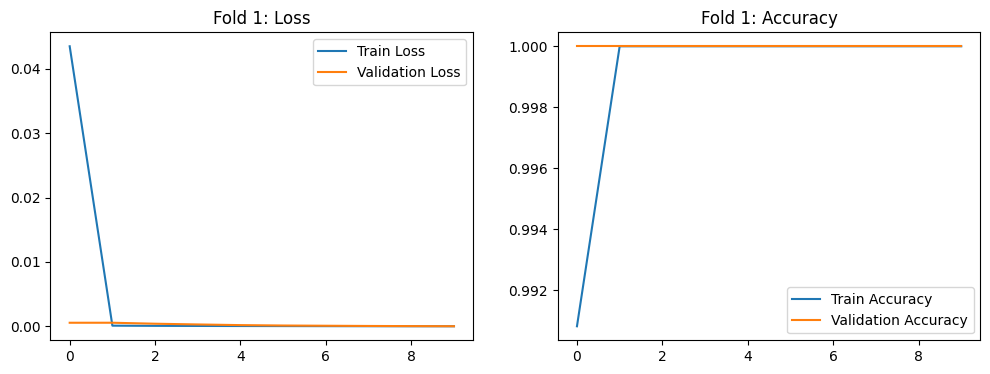

14/14 [==============================] - 1s 31ms/step


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

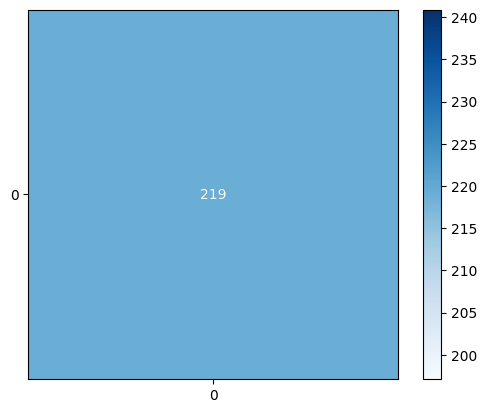

In [2]:
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

epochs = 10

# Função para carregar imagens e redimensioná-las
def load_and_resize_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    return np.array(img)

# Seus dados e rótulos
all_training_paths_cross_val = glob.glob('DATASETS/treino/*/*.jpg')
# Extrair rótulos das classes dos caminhos
y = [1 if 'With-Cancer' in path else 0 for path in all_training_paths_cross_val]

# Carregar imagens usando os caminhos
X = [load_and_resize_image(path) for path in all_training_paths_cross_val]
X = np.array(X)

# Inicialize o número do fold
fold_num = 1

# Defina o número de folds para a validação cruzada
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, val_index in skf.split(X, y):
    print(f"Fold {fold_num}/{num_folds}")

    # Separe os dados em conjuntos de treinamento e validação
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = np.array(y)[train_index], np.array(y)[val_index]

    # Adicione uma dimensão para representar o lote
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)

    # Repita os canais para que cada imagem tenha três canais
    X_train = np.repeat(X_train, 3, axis=-1)
    X_val = np.repeat(X_val, 3, axis=-1)

    # Crie os geradores de dados para treinamento e validação
    datagen_resnet_train = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.25)
    datagen_resnet_val = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.25)

    train_gen = datagen_resnet_train.flow(X_train, y_train, batch_size=16)
    val_gen = datagen_resnet_val.flow(X_val, y_val, batch_size=16)

    # Crie o modelo
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
    modelo_res = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])

    modelo_res.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

    # Defina callbacks
    model_checkpoint = ModelCheckpoint(f"best_model_fold{fold_num}.h5", save_best_only=True, monitor='val_loss', mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Treine o modelo com os geradores de dados e os callbacks
    history = modelo_res.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[model_checkpoint, early_stopping])

    # Mostrar gráficos de loss e accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f"Fold {fold_num}: Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f"Fold {fold_num}: Accuracy")

    plt.show()

 # Avaliar o modelo no conjunto de teste e mostrar matriz de confusão
test_gen = datagen_resnet_val.flow(X_val, y_val, batch_size=16, shuffle=False)
y_pred = modelo_res.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_val, y_pred_classes)

# Corrigir o desalinhamento
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Without-Cancer', 'With-Cancer'])
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())  # Passar o eixo corrente

plt.title(f"Fold {fold_num}: Confusion Matrix")
plt.show()

    fold_num += 1


### Apendices e analises para trabalhos futuros


In [ ]:

def predicao(modelo, path):
    image = Image.open(path)

# Redimensione a imagem
    resized_image = image.resize((224, 224))

    # Certifique-se de que a imagem seja colorida (3 canais)
    if resized_image.mode == 'L':
        # Converta a imagem em escala de cinza em uma imagem RGB (colorida)
        resized_image = resized_image.convert('RGB')

    # Converta a imagem redimensionada em uma matriz NumPy
    np_array = np.array(resized_image)

    
    img_np = preprocess_input(np_array)
    imp_np2=img_np.reshape(1,224,224,3)
    result = modelo_op.predict(imp_np2)
    id_max= result[0].argmax()
    index_to_class = {v: k for k, v in train_gen.class_indices.items()}
    plt.title(f'Resultado: {index_to_class[id_max]}')
    plt.imshow(resized_image)

In [ ]:
# criando um modelo de rede neural convolucional
modelo = Sequential(
    
)